<font color=darkgreen>
    
# Lecture 6.  CNN  with small datasets

## Training a convnet from scratch on a small dataset
- Data의 수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 feature를 찾을 수 있는데 있음 
  - 하지만 모델이 작고 regularization이 잘 되어 있다면 수백 개의 샘플로도 훈련 가능 
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 이미지의 색깔, 각도 등을 약간씩 변형하여 data의 수를 늘림 
    - Pre-trained network의 활용
        - ImageNet 등에서 학습된 기존의 모형과 weight를 불러온 후 목적에 맞게 약간 수정하여 모형 생성 

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 2000 for training, 1000 for validation, 1000 for testing 
- `git pull` 실행 후 `data` folder에서 `unzip cats_and_dogs_small.zip -d ./cats_and_dogs_small` 명령어 실행하면 `cats_and dogs_small` 폴더에 데이터 압축이 해제됨
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

## Build a network

- Input: $150 \times 150$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification with sigmoid activation) 
- Hidden layers:  `Conv2D`(with `relu` activation) + `MaxPooling2D`

In [0]:
def build_model(dropout_rate=0):
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    from keras.models import Sequential
    from keras import optimizers
    import keras.backend as K
    K.clear_session()

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    return model

## Data preprocessing

- CNN 입력을 위한 이미지 전처리 단계 
    * 사진 파일 읽기
    * JPEG content를 RBG 픽셀 값으로 디코딩
    * floating point tensor 형태로 변환 
    * 0-255 사이의 값을 가지는 픽셀 값을 [0,1] 사이 값으로 변환

- `keras.preprocessing.image.ImageDataGenerator`를 사용하여 자동으로 입력 가능한 형태로 변환할 수 있음

#### Generator가 무엇인가?
- Iterator를 생성해 주는 함수 
- Iterator: `next()`를 사용하여 데이터에 순차적으로 접근 가능한 object 
- 일반적인 함수는 사용이 종료되면 결과값을 반환하고 메모리 상에서 클리어 되지만 `yield`를 사용하는 generator는 `next()`를 통해 `yield`값을 반환 한 뒤 그 상태로 유지되어 이후의 `next()`에 의해 호출될 때 그 상태로 다시 시작함

In [0]:
def generator(n):
    i = 0
    while i < n:
        yield i
        i += 1
x=generator(5)

In [0]:
next(x)

0

In [0]:
[i for i in x]

[1, 2, 3, 4]

#### Keras의  ImageDataGenerator 클래스

- 학습을 위해 이미지에 임의의 변형을 적용 
- 변형된 이미지를 배치 단위로 생성하여 모형 학습시 사용하기 위한 generator를 생성 
- 데이터 전체가 순환되어 배치 생성을 끝없이 함
- `flow_from_directory(directory)` 메소드
    - 이미지가 특정 폴더 안에 분류 되어 있을 경우 subdirectory의 이름으로부터 target class를 자동으로 만들어냄
- [Keras ImageDataGenerator Documentation Link](https://keras.io/preprocessing/image/)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 지금은 다른 변형은 하지 않고 픽셀 값을 [0,1] 사이로 조정만 하는 generator 생성
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


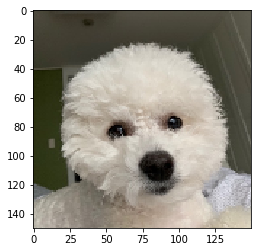

In [0]:
img_path = '/content/drive/My Drive/Deep_Learning_한국정보문화산업진흥원/2일차/figures/leo1.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)

In [0]:
# train, validation, test 이미지가 들어있는 폴더 경로를 지정
train_dir = '/content/drive/My Drive/Deep_Learning_한국정보문화산업진흥원/2일차/data/cats_and_dogs_small/train'
validation_dir = '/content/drive/My Drive/Deep_Learning_한국정보문화산업진흥원/2일차/data/cats_and_dogs_small/validation'
test_dir = '/content/drive/My Drive/Deep_Learning_한국정보문화산업진흥원/2일차/data/cats_and_dogs_small/test'

In [0]:
# 지정된 폴더의 이미지를 (20,150,150,3) 크기의 numpy array로 변환하여 생성해주는 generator
train_generator = train_datagen.flow_from_directory(
        train_dir, # 이미지가 들어있는 폴더. class마다 각 subdirectory로 저장되어 있어야 함
        target_size=(150, 150), # 모든 이미지를 (150,150) 크기로 조정
        batch_size=20,
        class_mode='binary' # 1D binary label의 생성
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- `train_generator`의 output
    - Batches of 150x150 RGB images (shape `(20, 150, 150, 3)`)
    - Binary labels (shape `(20,)`)
    - Batch size=20: the number of samples in each batch
- `ImageDataGenerator`는 이미지를 끝없이 생성하기 때문에 원하는 단계에서 `break`가 필요 
    

In [0]:
# 생성된 iterator로 batch 생성 후 확인
batch=next(train_generator)

In [0]:
# 2개의 요소를 가지는 tuple 형태가 생성됨
print(type(batch))
len(batch)

<class 'tuple'>


2

In [0]:
batch[0].shape # 생성된 tuple의 첫 번째 요소는 150*150*3의 이미지 20개

(20, 150, 150, 3)

In [0]:
batch[1] # 생성된 tuple의 두 번째 요소는 binary label

array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.], dtype=float32)

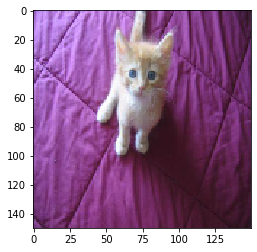

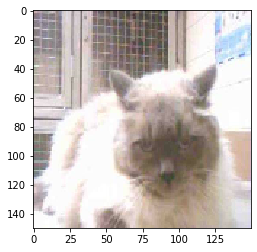

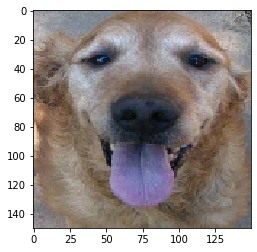

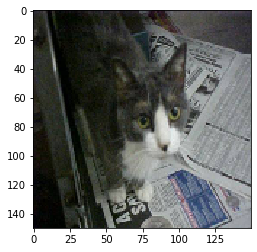

In [0]:
# 생성된 tuple의 이미지 확인 
for i in range(4):
    plt.figure(i)
    plt.imshow(batch[0][i])

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)



## Model fitting with Batch Generator

- `train_generator`를 사용하여 모델을 훈련할 때는 `model.fit` 대신 `model.fit_generator`를 사용 
- 훈련 데이터셋을 대신 (input, target)을 끝없이 반환하는 generator를 첫 argument로 입력
- `steps_per_epoch`: 한 epoch에서 몇 번의 gradient update를 진행할 것인가? 
    - `model.fit`를 사용할 때는 훈련데이터의 수가 정해져 있기 때문에 batch size를 결정해주면 한 epoch 당 gradient update의 횟수가 자동으로 정해졌음
    - `model.fit_generator`를 사용할 때는 훈련데이터가 끝없이 생성되기 때문에 다음 epoch로 넘어가기 전에 몇 번의 gradient update를 시행해 줄 것인지를 명시함
    - 한 batch가 20개 샘플을 포함하므로 아래의 경우 100*20=2000개의 샘플을 처리하면 한 epoch가 지나감
- `validation_data`: `validation_generator`를 사용하여 validation data를 생성. `(x_val, y_val)`과 같이 tuple 형태의 validation data를 지정할 수도 있음
- `validation_steps`: `validation_data`에 generator를 지정했을 때만 사용하며 몇 번의 data generation을 통해 validataion data를 만들어 낼 것인가를 결정. 아래의 경우 50*20=1000개를 사용. 일반적으로 validation data 개수를 batch_size로 나눈 값으로 지정

In [0]:
from keras.callbacks import TensorBoard

In [0]:
model=build_model()
callbacks_list = [TensorBoard(log_dir='./logs/cats_and_dogs/noaug')]
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks_list
)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/30
 15/100 [===>..........................] - ETA: 9:54 - loss: 0.7021 - acc: 0.5033 

KeyboardInterrupt: ignored

In [0]:
#model.save('cats_and_dogs_small_1.h5')

![](figures/noaug.PNG)



- Overfitting 발생 
    - Training accuracy는 계속 증가하지만 validation accuracy는 70-72%에서 움직임
    - Training sample이 2000개 


In [39]:
from keras.models import load_model

model=load_model('/content/drive/My Drive/Deep_Learning_한국정보문화산업진흥원/2일차/cats_and_dogs_small_1.h5')
model.evaluate_generator(test_generator, steps=50)

[0.8163547638058662, 0.7400000011920929]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
img_path = '/content/drive/My Drive/Deep_Learning_한국정보문화산업진흥원/2일차/figures/leo2.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=model.predict(x)
print('Prob(dog): %f'%(pred))

FileNotFoundError: ignored

***
## Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯한 이미지를 랜덤하게 생성하여 데이터의 수를 늘리는 data augmentation 적용 
    * `rotation_range`: random rotation 각도 범위(0-180)
    * `width_shift_range, `height_shift_range`: 수평 혹은 수직 이동 범위(비율) 
    * `shear_range`: 기울어지는 변환(shearing transformation)의 각도 범위(반시계방향)
    * `zoom_range`: 확대 비율([lower, upper] = [1-zoom_range, 1+zoom_range])
    * `horizontal_flip`: 수평으로 뒤집음(mirror image)
    * `fill_mode`: 변환된 이미지에서 생기는 빈 부분을 채우는 방법




#### Defining a data generator

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# validation set은 augmentation을 하지 않고 있는 데이터 그대로를 사용
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

#### Checking augmented image samples
- `train_datagen`이 변환하는 이미지를 체크하기 위해 하나의 훈련이미지를 선택하고 변환된 이미지를 프린트

In [0]:
image_path=train_dir+'/dogs/dog.4.jpg' # 
x=image.load_img(image_path, target_size=(150,150))
x

In [0]:
x=image.img_to_array(x)
x=np.expand_dims(x,axis=0)


In [0]:
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

#### Building and fitting a model
- Model에 dropout layer를 추가하여 data augmentation과 더불어 overfitting 방지 

In [0]:
model=build_model(dropout_rate=0.5)
callbacks_list = [TensorBoard(log_dir='./logs/cats_and_dogs/aug')]
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks_list
)

In [0]:
#model.save('cats_and_dogs_small_2.h5')

![](figures/aug.PNG)

- Data augmentation과  dropout을 통해 overfitting이 상당부분 해결되었음 
- Validation accuracy가 82%로 성능이 향상됨 

In [0]:
model=load_model('cats_and_dogs_small_2.h5')

OSError: ignored

In [0]:
model.evaluate_generator(test_generator, steps=50)

NameError: ignored

In [0]:
img_path = 'figures/leo1.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=model.predict(x)
print('Prob(dog): %f'%(pred))


References
- [Deep Learning with Python, François Chollet,](https://www.manning.com/books/deep-learning-with-python)